In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import pandas as pd
import math
%matplotlib inline

# Color Clusters

In this notebook I find the most popular color of each movie's poster.

## Most Popular Color (rgb)

I start by making a couple of functions that will help me with this process

In [1]:
def get_most_popular_color(html):
    """
    return rgb value of the most popular color in an html image
    
     Parameters
    ----------
    html : string
        the html address of the image of the movie poster
    """
    response = requests.get(html)
    try:
        img = np.array(Image.open(BytesIO(response.content)))
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        clt = KMeans(n_clusters = 3)
        clt.fit(img)
        colorMax = tuple(clt.cluster_centers_[
                np.argmax(np.histogram(clt.labels_, bins = np.arange(0, len(np.unique(clt.labels_)) + 1))[0])])
        return colorMax
    except:
        return 'None'

In [3]:
def graph_color(c):
    """ graphs the most popular color from an image as a square """
    (r,g,b) = c
    c = (r/255, g/255, b/255)
    plt.plot([0,0], lw=400, color = c)
    plt.axis('off')
    plt.show()

Here is an example of the code at work with the classic Jurassic Park movie poster:

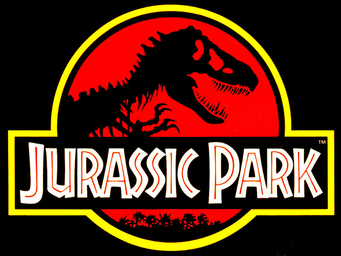

In [4]:
url = "https://upload.wikimedia.org/wikipedia/en/9/96/Jurassic_Park_logo.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

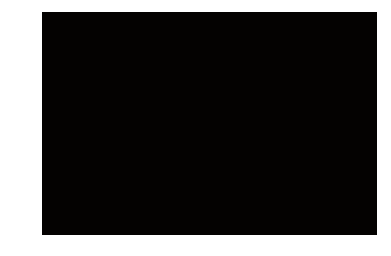

In [5]:
color1 = get_most_popular_color(url)
graph_color(color1)

As you can see, it returns black which makes sense.

This applies to all pictures as well.

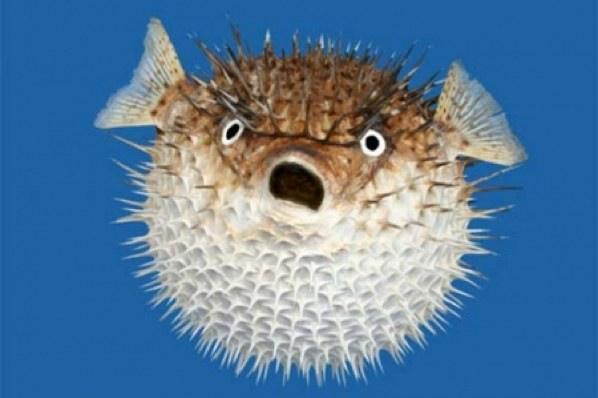

In [6]:
url = "http://easyscienceforkids.com/wp-content/uploads/2013/06/puffer-fish.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

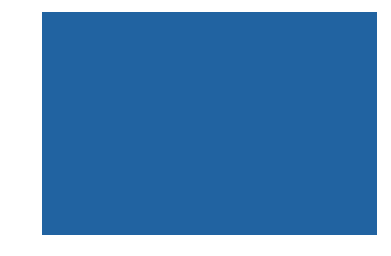

In [7]:
color2 = get_most_popular_color(url)
graph_color(color2)

## Naming Colors

In order to make this data more helpful for my model, I need to classify the rgb values as colors so that I can categorize each poster.

I start by making a dictionary of the color categories I will use.

In [8]:
rgb_code_dictionary = { (255, 255, 0): 'yellow',
(255, 0, 255): 'magenta',
(0, 255, 255): 'cyan',
(255, 0, 0): 'red',
(255, 125, 125): 'light red',
(0, 255, 0): 'green',
(122,225,122): 'light green',
(0, 0, 255): 'blue',
(100, 100, 255): 'light blue',
(255, 255, 255): 'white',
(0, 0, 0): 'black',
(210, 180, 140): 'tan',
(125, 0, 0): 'dark red',
(0, 125, 0): 'dark green',
(0, 0, 125): 'dark blue'}

I then make some functions that will define the color name of the rgb values

In [9]:
def distance(c1, c2):
    """ returns the squared distance between two colors
    
    Params
    ---------
    c1 : tuple
        Color number 1
    c2 : tuple
        Color number 2
    """
    (r1,g1,b1) = c1
    (r2,g2,b2) = c2
    return math.sqrt((r1 - r2)**2 + (g1 - g2) ** 2 + (b1 - b2) **2)

In [10]:
def return_text_color(point):
    """ return the color name of the closest color in the dictionary
    
    Params
    ---------
    point : tuple
        Color to define
    """
    colors = list(rgb_code_dictionary.keys())
    closest_colors = sorted(colors, key=lambda color: distance(color, point))
    closest_color = closest_colors[0]
    return rgb_code_dictionary[closest_color]

Now to see it in action with the colors we found earlier

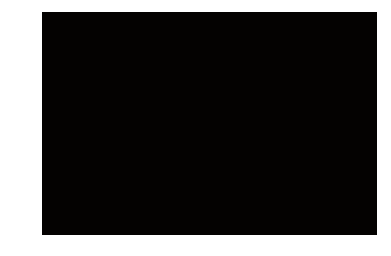

'black'

In [11]:
graph_color(color1)
return_text_color(color1)

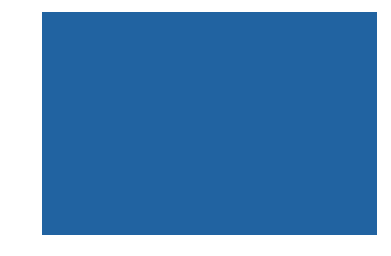

'dark blue'

In [12]:
graph_color(color2)
return_text_color(color2)

## Applying to Data Set

Now to apply this to the dataset in order to help the model

I read in the urls and drop the values that are NaN

In [13]:
movies = pd.read_csv('/data/kylevigil/movies.dat', delimiter = '\t', encoding = 'ISO-8859-1', index_col=0)
movies = movies[['imdbPictureURL']]
movies = movies.dropna()

In [23]:
assert len(movies[[len(i) < 50 for i in movies.imdbPictureURL]]) == 0

Then I use the functions above to make a new column of the most popular color for each of the URLs. 
# IMPORTANT NOTE: this next cell takes up to 1.5 hours!!!

In [ ]:
#movies['color'] = [get_most_popular_color(i) for i in movies.imdbPictureURL]

I drop all colors that weren't able to be found, there were only 30 or so of them.

In [21]:
movies = movies[movies.color != 'None']

In [22]:
movies.head()

,imdbPictureURL,color,posterColor
id,,,
1,http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,"(104.392166836, 54.7272562127, 43.522889115)",dark red
2,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,"(139.494224539, 107.210170447, 69.5860332441)",tan
3,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,"(240.257754103, 245.865108686, 244.831228342)",white
4,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,"(245.888900917, 241.470051238, 222.634877679)",white
5,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,"(66.3822844645, 58.6215606039, 44.2912374771)",dark red


Now I make another column for the closest color text in the movie poster.

In [24]:
movies['posterColor'] = [return_text_color(i) for i in movies.color]

In [25]:
movies.head()

,imdbPictureURL,color,posterColor
id,,,
1,http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,"(104.392166836, 54.7272562127, 43.522889115)",dark red
2,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,"(139.494224539, 107.210170447, 69.5860332441)",tan
3,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,"(240.257754103, 245.865108686, 244.831228342)",white
4,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,"(245.888900917, 241.470051238, 222.634877679)",white
5,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,"(66.3822844645, 58.6215606039, 44.2912374771)",dark red


In [27]:
movies.posterColor.value_counts()

black          4168
white          2264
tan            1327
dark red        818
dark blue       411
light red       333
light green     228
light blue      182
dark green       89
red              71
yellow           62
cyan              7
blue              1
Name: posterColor, dtype: int64

## Saving

Finally I save the important data as colors.pkl

In [28]:
movies[['posterColor','color']].to_pickle('/data/kylevigil/colors.pkl')